## Calculating a Peri-Stimulus Time Histogram (PSTH):

For NX-435 by Mackenzie Mathis

### What is a PSTH?

It's a common tool used in neuroscience to analyze the firing patterns of neurons in response to a stimulus.

The Peri-Stimulus Time Histogram (PSTH) plots the average firing rate of a neuron over time relative to the onset of a stimulus. Here's how it's typically calculated:

1. Define a time window around the onset of the stimulus.
2. Divide this time window into small bins.
3. Count the number of spikes (action potentials) that occur within each bin across multiple trials.
4. Average the spike counts across trials for each bin.
5. Plot the average spike count (firing rate) for each bin as a function of time.

The PSTH provides insights into the temporal dynamics of neuronal responses to a stimulus. It's commonly used to study sensory processing, motor control, and other aspects of neural coding. By analyzing the PSTH, researchers can infer how neurons encode information about stimuli and how their firing rates change over time in response to different experimental conditions.

It also allows you to both visulaize AND quantify neural spiking consistency across trials!

- This notebook uses mostly standard python libraries, with the addition of the tdt package to grab some demo data (thanks!)

In [40]:
pip install tdt

Note: you may need to restart the kernel to use updated packages.


In [41]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tdt

Demo code/data from here: https://www.tdt.com/docs/sdk/offline-data-analysis/offline-data-python/examples/03_RasterPSTH/#housekeeping

In [42]:
tdt.download_demo_data()
BLOCK_PATH = 'data/Algernon-180308-130351'

demo data ready


### There are 16 channels on this recording array; therefore you can look at any channel for computing a PSTH

- the assumption is each channel here is an undividual unit (neuron), which is extracted after spike sorting.

- if you want to look at other channels, just change the cell below and re-run the cells below it.

In [43]:
CHANNEL = 3 #3 is default

In [44]:
REF_EPOC = 'PC0/'
SNIP_STORE = 'eNe1'
SORTID = 'TankSort'
SORTCODE = 0          # set to 0 to use all sorts
TRANGE = [-0.3, 0.8]
data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)


#Next we will do a bit of preprocessing; Using the `t` parameter extracts data only from the time range around the defined epoc event.
raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
#Adding the `tref` flag takes the timestamps relative to the epoc event:
hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

ts = raster_data.snips[SNIP_STORE].ts
if SORTCODE != 0:
    i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
    ts = ts[i]
if len(ts) == 0:
    raise Exception('no matching timestamps found')

num_trials = raster_data.time_ranges.shape[1]

read from t=0s to t=61.23s


In [45]:
raster_data

epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 3.20019584,  6.70018688, 10.20017792, 13.70016896, 17.20016   ,
        20.70015104, 24.20014208, 27.70013312, 31.20012416, 34.7001152 ,
        38.20010624, 41.70009728, 45.20008832, 48.70007936, 52.2000704 ,
        55.70006144, 59.20005248],
       [ 4.00019584,  7.50018688, 11.00017792, 14.50016896, 18.00016   ,
        21.50015104, 25.00014208, 28.50013312, 32.00012416, 35.5001152 ,
        39.00010624, 42.50009728, 46.00008832, 49.50007936, 53.0000704 ,
        56.50006144, 60.00005248]])
time_ref:	[-0.3, 0.8]
filter:	'TIME:PC0/ [-0.3:0.8];'

## Okay, data loading and a bit of pre-processing is done!

- now we will start making some plots and explore the data!
- Let's plot the spikes in bins across time for all the trials (combined):

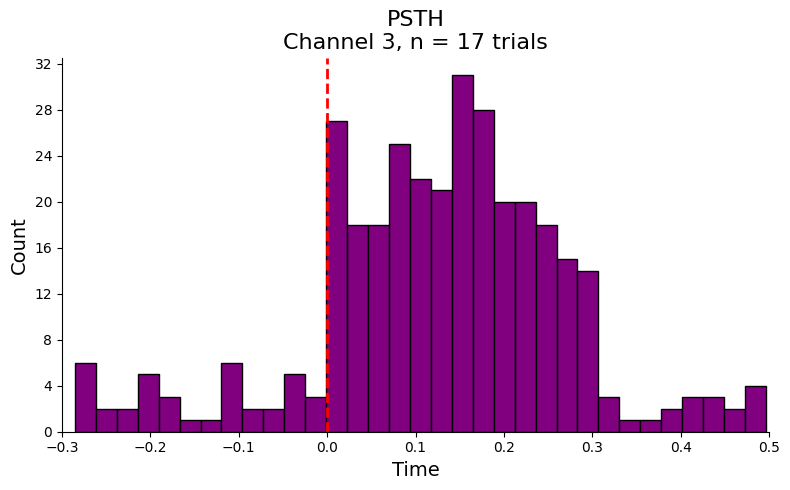

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))

hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts) / 10.))
hist_n, bins, _ = ax.hist(hist_ts, nbins, color='purple', edgecolor='black')

ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_title('PSTH\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0.
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

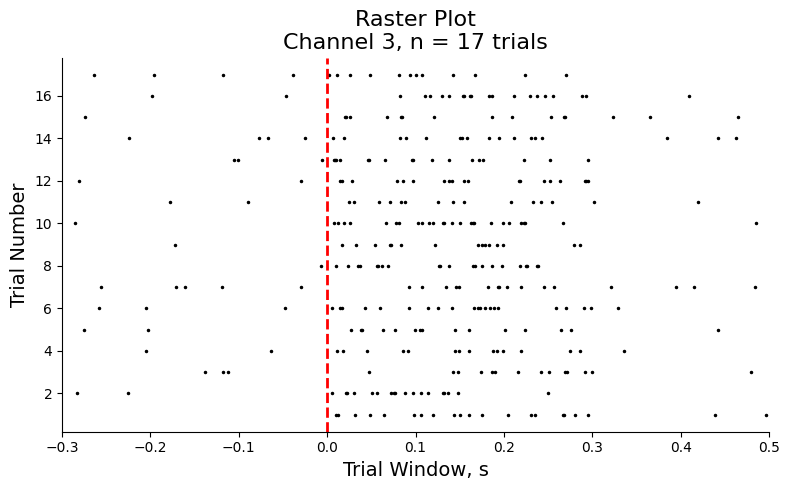

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))

# For the raster plot
all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax.plot(all_x, all_y, 'k.', markersize=3)
ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax.set_xlabel('Trial Window, s', fontsize=14)
ax.set_ylabel('Trial Number', fontsize=14)
ax.set_title('Raster Plot\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0.
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis.
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## If you want to plot them together:

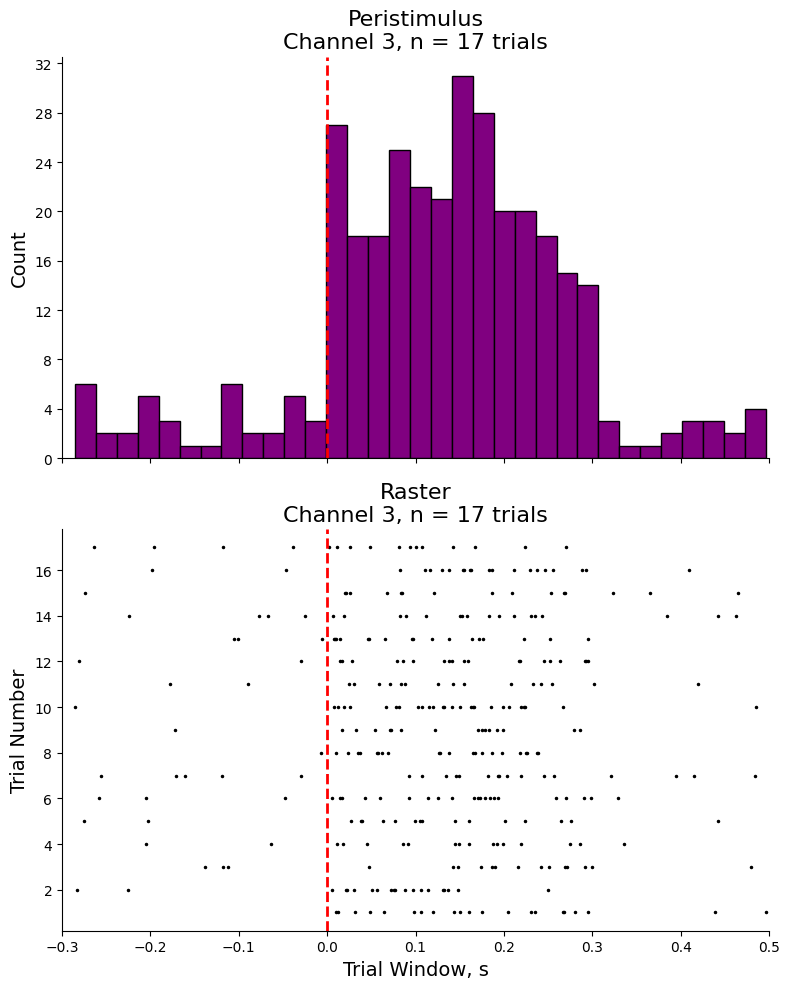

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot histogram (counts)
hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts) / 10.))
hist_n, bins, _ = ax1.hist(hist_ts, nbins, color='purple', edgecolor='black')

ax1.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0 for histogram
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis for histogram
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines for histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# For the raster plot
all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax2.plot(all_x, all_y, 'k.', markersize=3)
ax2.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
ax2.set_xlabel('Trial Window, s', fontsize=14)
ax2.set_ylabel('Trial Number', fontsize=14)
ax2.set_title('Raster\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=16)

# Draw a vertical line at t=0 for raster
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Set integer ticks on y-axis for raster
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines for raster
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Let's examine the mean and standard deviation across trials

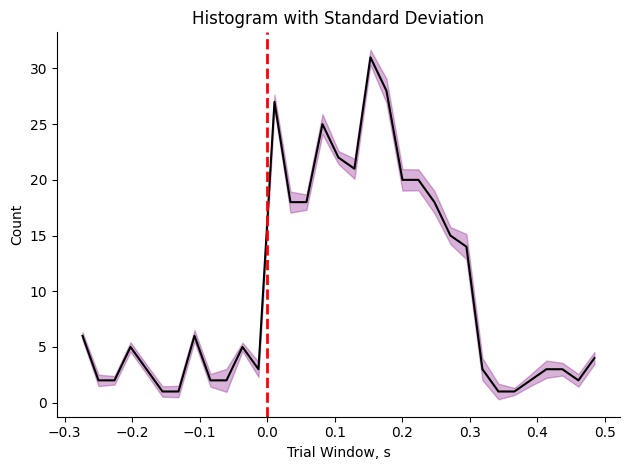

In [49]:
# Compute standard deviation per time bin
bin_stds = []
for i in range(nbins):
    bin_values = []
    for trial in range(num_trials):
        trial_ts = all_ts[trial]
        counts, bin_edges = np.histogram(trial_ts, bins=nbins)
        bin_values.append(counts[i])
    bin_stds.append(np.std(bin_values))

bin_stds = np.array(bin_stds)

# Plot mean plus standard deviation
bin_centers = (bins[:-1] + bins[1:]) / 2

# Connect the dots
plt.plot(bin_centers, hist_n, color='black')

# Shade the error bars
plt.fill_between(bin_centers, hist_n - bin_stds, hist_n + bin_stds, color='purple', alpha=0.3)

# Draw a vertical line at t=0 for histogram
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Trial Window, s')
plt.ylabel('Count')
plt.title('Histogram with Standard Deviation')
plt.tight_layout()
plt.show()

## Alright, so lets just flag when the count (firing) in a given bin is > the mean+/-STD firing during the baseline period (before stimulus onset):

Mean count rate in baseline:  3.0 +/- 7.0


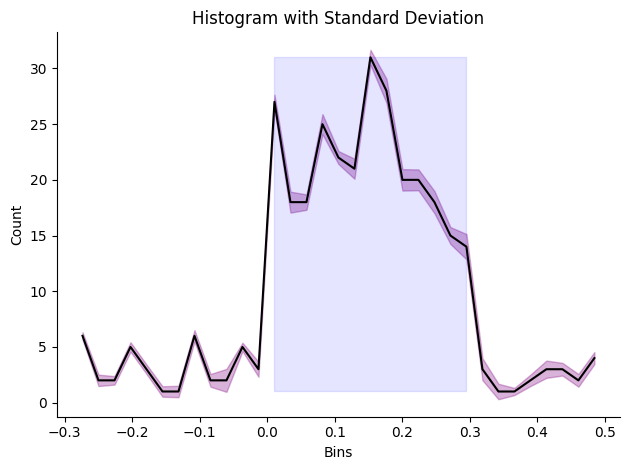

In [50]:
#NOTE:
#bins is the time axis
#hist_n is the count

# Compute mean firing rate before stimulus onset (i.e, what is the mean count before time 0?)
mean_firing_rate_before_stimulus = np.mean(hist_n[bins[1:] < 0])
std_firing_rate_before_stimulus = np.std(hist_n[bins[:-1] < 0])
print("Mean count rate in baseline: ", np.round(mean_firing_rate_before_stimulus), "+/-",np.round(std_firing_rate_before_stimulus))


# Compare each bin count to the mean firing rate before stimulus onset plus/minus one standard deviation
flag = np.logical_and(hist_n > (mean_firing_rate_before_stimulus + std_firing_rate_before_stimulus),
                              hist_n > (mean_firing_rate_before_stimulus - std_firing_rate_before_stimulus))

# Plot mean plus standard deviation
bin_centers = (bins[:-1] + bins[1:]) / 2

# Connect the dots
plt.plot(bin_centers, hist_n, color='black')

# Shade the error bars
plt.fill_between(bin_centers, hist_n - bin_stds, hist_n + bin_stds, color='purple', alpha=0.3)

# Highlight bins with significant difference
plt.fill_between(bin_centers, np.min(hist_n), np.max(hist_n), where=flag, color='blue', alpha=0.1)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Histogram with Standard Deviation')
plt.tight_layout()
plt.show()


# Lastly, lets look at all the recorded neural data together

- bonus: can you then plot the mean count for each CHANNEL?

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


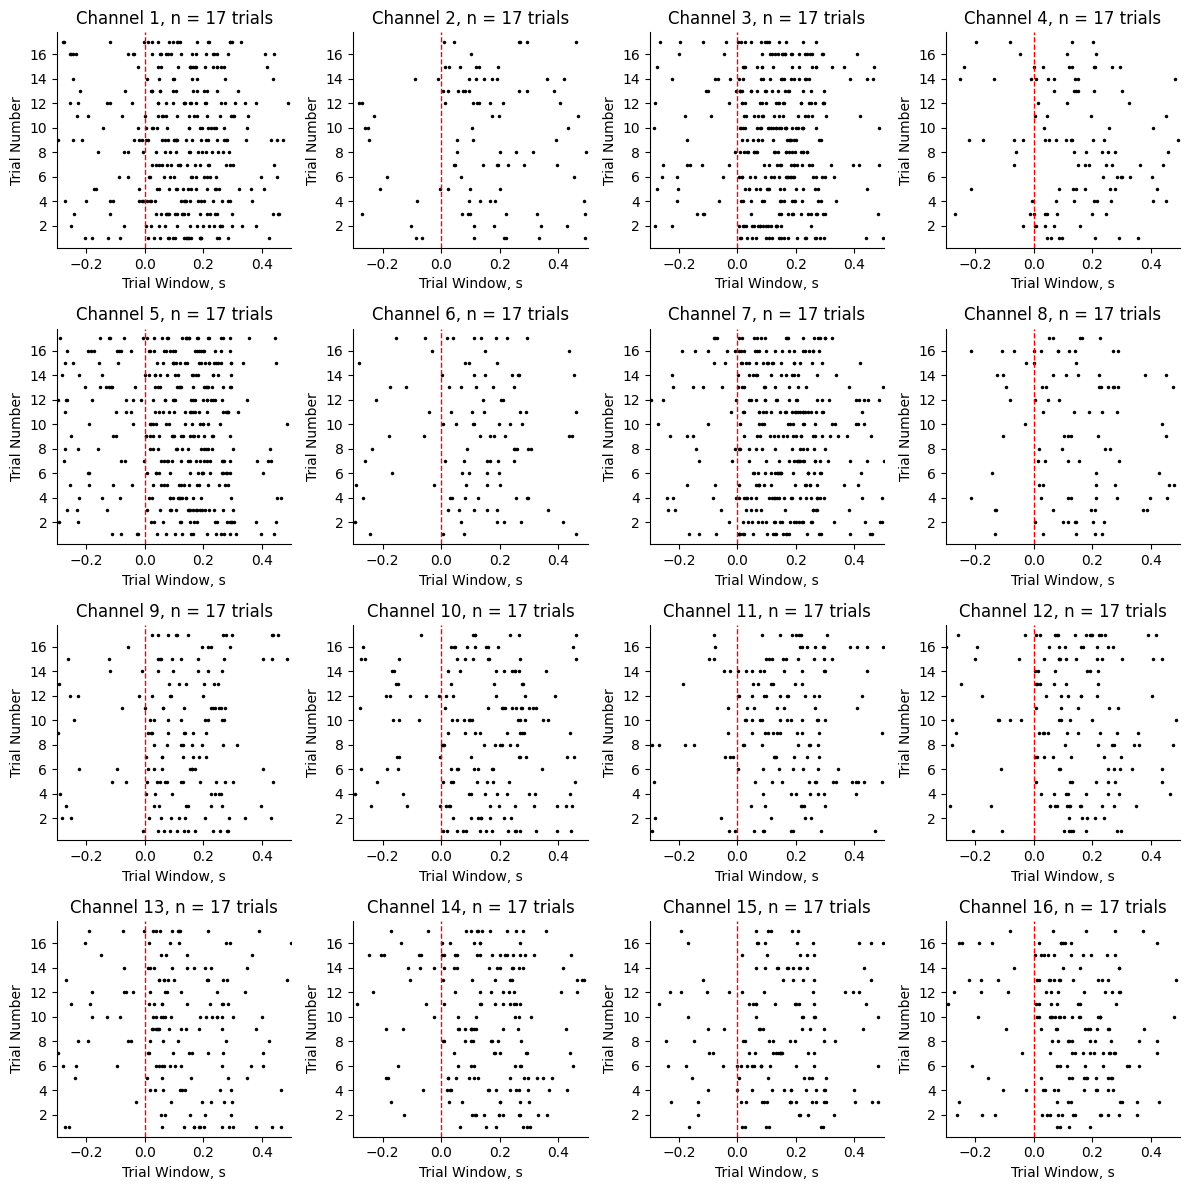

In [51]:
def plot_raster_subplot(ax, raster_data, TRANGE, CHANNEL):
    # Extract data for the specified channel
    data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)

    # Preprocess data
    raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
    hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

    ts = raster_data.snips[SNIP_STORE].ts
    if SORTCODE != 0:
        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
        ts = ts[i]
    if len(ts) == 0:
        raise Exception('no matching timestamps found')

    num_trials = raster_data.time_ranges.shape[1]

    # For the raster plot
    all_ts = [[] for x in range(num_trials)]
    all_y = [[] for x in range(num_trials)]
    for trial in range(num_trials):
        trial_on = raster_data.time_ranges[0, trial]
        trial_off = raster_data.time_ranges[1, trial]
        ind1 = ts >= trial_on
        ind2 = ts < trial_off
        trial_ts = ts[ind1 & ind2]
        all_ts[trial] = trial_ts - trial_on + TRANGE[0]
        all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

    all_x = np.concatenate(all_ts)
    all_y = np.concatenate(all_y)

    # Make the raster plot.
    ax.plot(all_x, all_y, 'k.', markersize=3)
    ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
    ax.set_xlabel('Trial Window, s', fontsize=10)
    ax.set_ylabel('Trial Number', fontsize=10)
    ax.set_title('Channel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=12)

    # Draw a vertical line at t=0.
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # Set integer ticks on y-axis.
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Remove top and right spines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Iterate over rows and columns to plot each subplot
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        # Calculate the current channel based on the loop indices
        CHANNEL = i * 4 + j + 1
        plot_raster_subplot(ax, raster_data, TRANGE, CHANNEL)

plt.tight_layout()
plt.show()

# BONUS: clustering the cells by their PSTH signature
- here we will use PCA with k-means clustering to cluster into 3 groups (you can test if more or less is best!)
- color by cluster ID

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


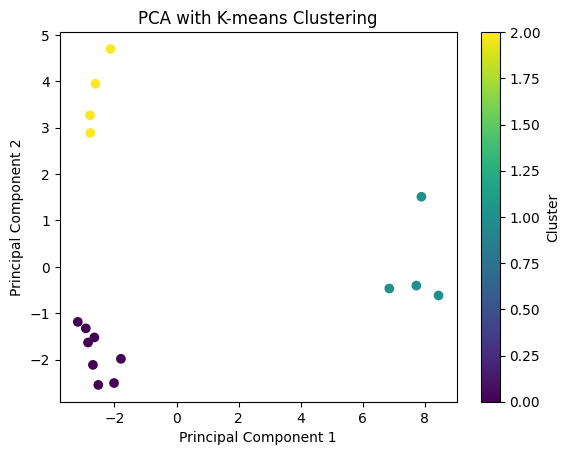

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def read_data_for_channel(channel):
    # Extract data for the specified channel
    data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=channel, nodata=1)
    # Preprocess data
    raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
    hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)
    ts = raster_data.snips[SNIP_STORE].ts
    if SORTCODE != 0:
        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
        ts = ts[i]
    if len(ts) == 0:
        raise Exception('no matching timestamps found')
    num_trials = raster_data.time_ranges.shape[1]
    # Calculate PSTH data
    hist_ts = hist_data.snips[SNIP_STORE].ts
    nbins = np.int64(np.floor(len(hist_ts) / 10.))
    hist_n, _ = np.histogram(hist_ts, nbins)
    return hist_n


# Read PSTH data for each channel and store in a list
psth_data = []
max_nbins = 0  # Track the maximum number of bins among all channels
for channel in range(1, 17):  # Assuming there are 16 channels
    hist_n_channel = read_data_for_channel(channel)
    psth_data.append(hist_n_channel)
    max_nbins = max(max_nbins, len(hist_n_channel))

# Pad or truncate the PSTH data to ensure consistent shape
for i in range(len(psth_data)):
    psth_data[i] = np.pad(psth_data[i], (0, max_nbins - len(psth_data[i])), mode='constant', constant_values=0)

# Convert the list of PSTH data into a numpy array
psth_data = np.array(psth_data)

# Preprocess the data (standardize it)
scaler = StandardScaler()
scaled_psth_data = scaler.fit_transform(psth_data)

# Apply PCA
pca = PCA(n_components=2)  # You can adjust the number of components as needed
pca_result = pca.fit_transform(scaled_psth_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(pca_result)

# Visualize the clusters (optional)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()



## Color by channel ID:
- this assumes you have run the cell above

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


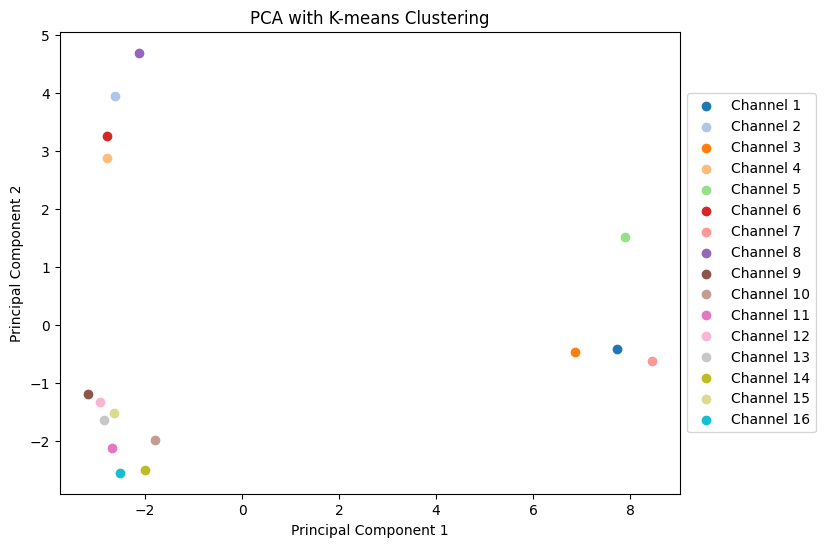

In [53]:
from matplotlib.lines import Line2D

# Read PSTH data for each channel and store in a list
psth_data = []
channel_ids = []  # Store channel IDs
max_nbins = 0  # Track the maximum number of bins among all channels
for channel in range(1, 17):  # Assuming there are 16 channels
    hist_n_channel = read_data_for_channel(channel)
    psth_data.append(hist_n_channel)
    channel_ids.append(channel)
    max_nbins = max(max_nbins, len(hist_n_channel))

# Pad or truncate the PSTH data to ensure consistent shape
for i in range(len(psth_data)):
    psth_data[i] = np.pad(psth_data[i], (0, max_nbins - len(psth_data[i])), mode='constant', constant_values=0)

# Convert the list of PSTH data into a numpy array
psth_data = np.array(psth_data)

# Standardize the data
scaler = StandardScaler()
scaled_psth_data = scaler.fit_transform(psth_data)



# Apply PCA
pca = PCA(n_components=2)  # You can adjust the number of components as needed
pca_result = pca.fit_transform(scaled_psth_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(pca_result)

# Visualize the clusters with colored dots and add a legend
plt.figure(figsize=(8, 6))
legend_elements = []
for i, channel_id in enumerate(channel_ids):
    color = plt.cm.tab20(i / len(channel_ids))
    plt.scatter(pca_result[channel_id - 1, 0], pca_result[channel_id - 1, 1], color=color, label='Channel {}'.format(channel_id))
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Channel {}'.format(channel_id), markerfacecolor=color, markersize=8))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with K-means Clustering')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# Do these clusters make sense? Let's inspect them.

- you can iteratively change the channels to plot based on the clustering above ^ !

read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s
read from t=0s to t=61.23s


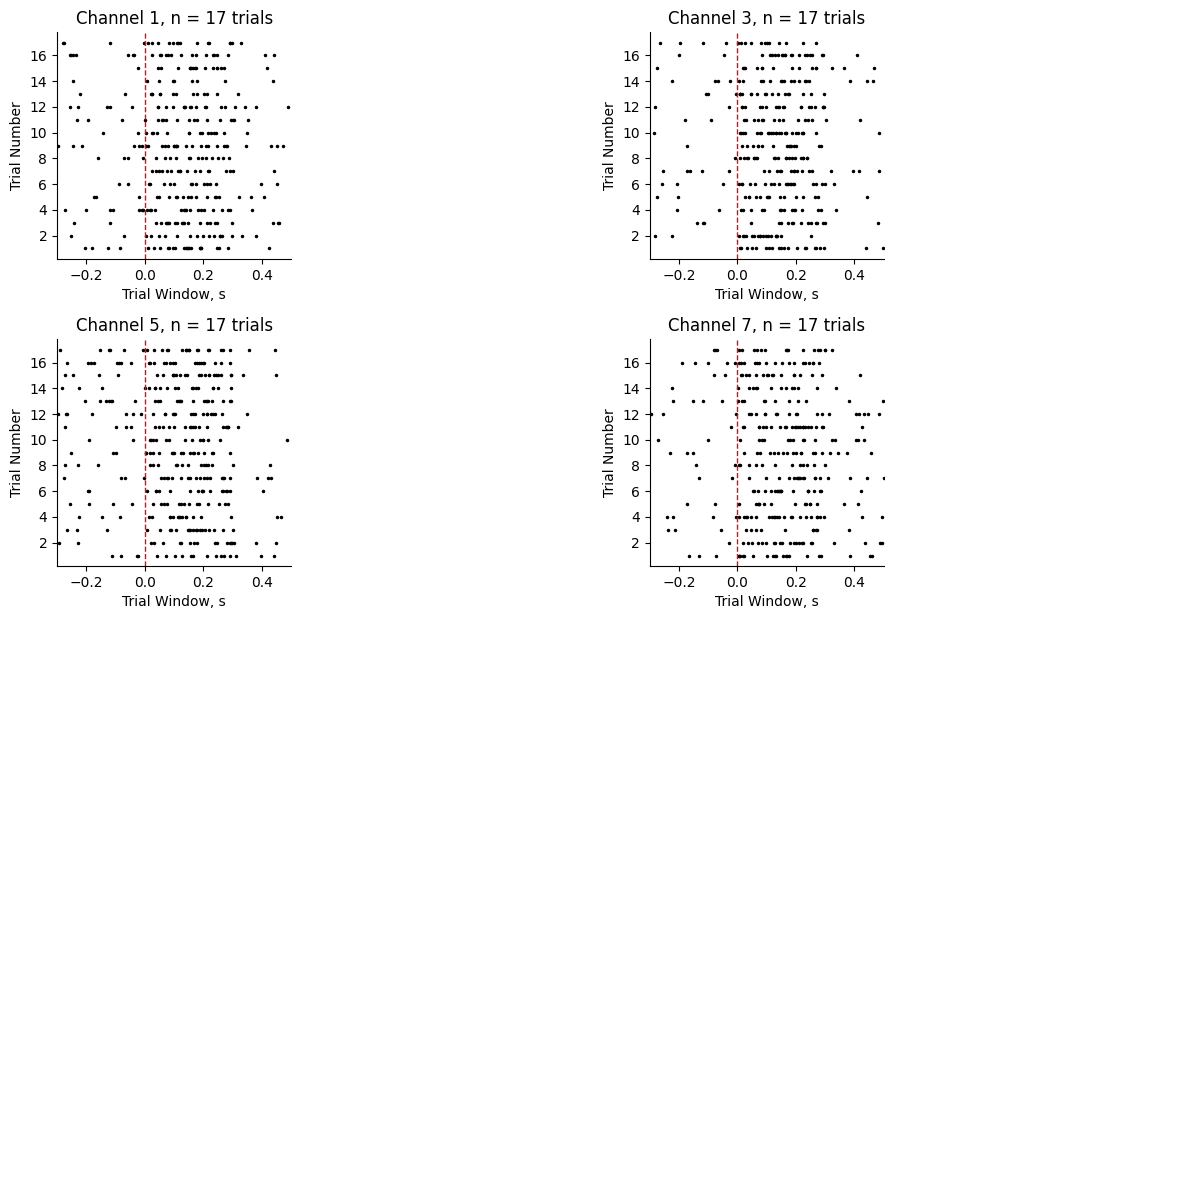

In [54]:
# List of channels to plot:

channels_to_plot = [1, 3, 7, 5]
#channels_to_plot = [4, 6, 2, 8]
#channels_to_plot = [16, 15, 14, 13, 12, 10, 9]

def plot_cluster_subplot(ax, raster_data, TRANGE, CHANNEL):
    # Extract data for the specified channel
    data = tdt.read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)

    # Preprocess data
    raster_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE)
    hist_data = tdt.epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

    ts = raster_data.snips[SNIP_STORE].ts
    if SORTCODE != 0:
        i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
        ts = ts[i]
    if len(ts) == 0:
        raise Exception('no matching timestamps found')

    num_trials = raster_data.time_ranges.shape[1]

    # For the raster plot
    all_ts = [[] for x in range(num_trials)]
    all_y = [[] for x in range(num_trials)]
    for trial in range(num_trials):
        trial_on = raster_data.time_ranges[0, trial]
        trial_off = raster_data.time_ranges[1, trial]
        ind1 = ts >= trial_on
        ind2 = ts < trial_off
        trial_ts = ts[ind1 & ind2]
        all_ts[trial] = trial_ts - trial_on + TRANGE[0]
        all_y[trial] = (trial + 1) * np.ones(len(trial_ts))

    all_x = np.concatenate(all_ts)
    all_y = np.concatenate(all_y)

    # Make the raster plot.
    ax.plot(all_x, all_y, 'k.', markersize=3)
    ax.set_xlim(left=TRANGE[0], right=TRANGE[0] + TRANGE[1])
    ax.set_xlabel('Trial Window, s', fontsize=10)
    ax.set_ylabel('Trial Number', fontsize=10)
    ax.set_title('Channel {0}, n = {1} trials'.format(CHANNEL, num_trials), fontsize=12)

    # Draw a vertical line at t=0.
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # Set integer ticks on y-axis.
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Remove top and right spines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))



# Iterate over rows and columns to plot each subplot
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        # Calculate the current channel based on the loop indices
        CHANNEL = i * 4 + j + 1
        if CHANNEL in channels_to_plot:
            plot_cluster_subplot(ax, raster_data, TRANGE, CHANNEL)
        else:
            ax.axis('off')  # Turn off the axes for channels not to be plotted

plt.tight_layout()
plt.show()

# BONUS: exercise for computing the auROC

- In the work from **Cohen et al, 2012 Nature** they use the auROC to measure how a neuron was changing its firing rate relative to baseline. This is a more rigous way to do this than just using the PSTH.

- From their paper: "*We calculated the area under the ROC curve (auROC) at each time bin. Values greater than 0.5 indicate increases in firing rate relative to baseline, whereas values less than 0.5 indicate decreases*".
- You can read more about how they computed this: https://static-content.springer.com/esm/art%3A10.1038%2Fnature10754/MediaObjects/41586_2012_BFnature10754_MOESM257_ESM.pdf See Supplemental Figure 1 (shown here):

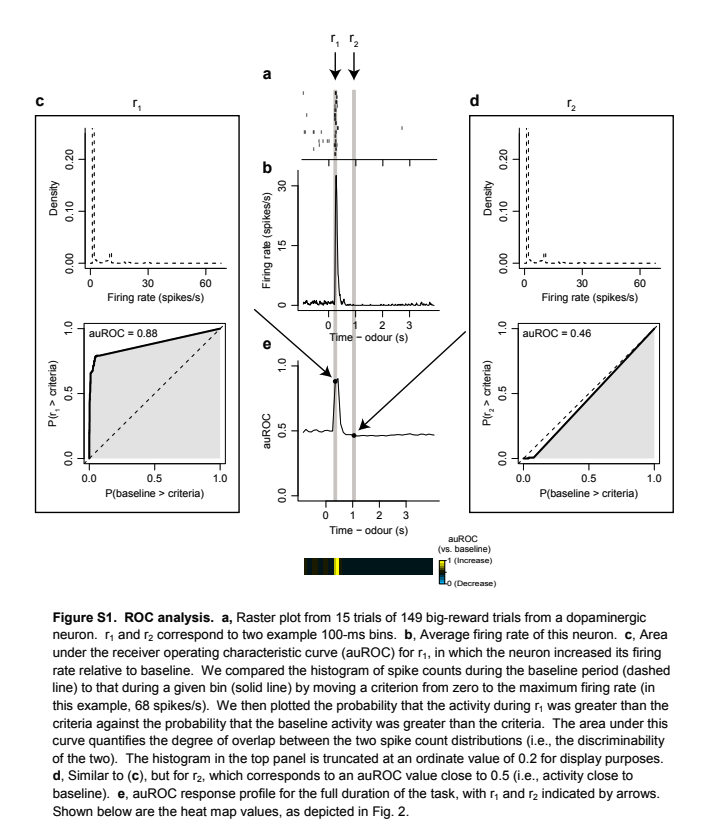

## Can you compute the ROC?


In the header we specified the range of time to be from -0.3 seconds to 0.5. We can define the baseline period as the bins before the odor onset ([-0.3, 0[) , and non-baseline period as the bins between [0, 0.3[ (based on significant difference firing rate to baseline in the histogram seen above).

### Compute ROC

In [55]:
# split hist_n into baseline period and non-baseline period

### write your code here
baseline_bin = hist_n[np.where(bins<0)[0][:-1]]
non_baseline_bin = hist_n[np.where((bins>0) & (bins<0.3))[0][:-1]] #NOTE: you can play with that range to see the auROC value varying

In [56]:
# initialise thresholds array (from 0 to max firing rate)

thresholds = np.linspace(0, np.max(non_baseline_bin), 100)

In [57]:
#fill gaps in the following function:

def compute_probabilities(array, thresholds):
    """
    Computes the probabilities of elements in the input array being greater than each of the given thresholds.

    This function iterates over a list of thresholds and, for each threshold, calculates the proportion
    of elements in the input array that are greater than that threshold. This is effectively measuring
    the probability of an element in the array exceeding each threshold, assuming the array represents
    a random sample.

    Parameters:
    - array (np.ndarray): A numpy array of numerical values. It should be a 1-dimensional array.
    - thresholds (list or np.ndarray): A list or 1-dimensional numpy array of numerical thresholds.

    Returns:
    - list: A list of probabilities. Each probability corresponds to the proportion of elements in
            'array' that exceed the respective threshold in 'thresholds'.

    Example:
    >>> compute_probabilities(np.array([1, 2, 3, 4, 5]), [2, 3])
    [0.6, 0.4]

    This indicates that 60% of the elements are greater than 2 and 40% are greater than 3 in the input array.
    """
    probabilities = []
    
    ### write your code here
    for threshold in thresholds:
      probabilities.append([np.mean(array>threshold)])

    return probabilities

In [58]:
assert compute_probabilities(np.array([1, 2, 3, 4, 5]), [2, 3]) == [[0.6], [0.4]] # test our function works

In [59]:
# compute those probabilities for baseline histogram
# and corresponding bin histogram

### your code here
baseline_proba = compute_probabilities(baseline_bin, thresholds)
non_baseline_proba = compute_probabilities(non_baseline_bin, thresholds)


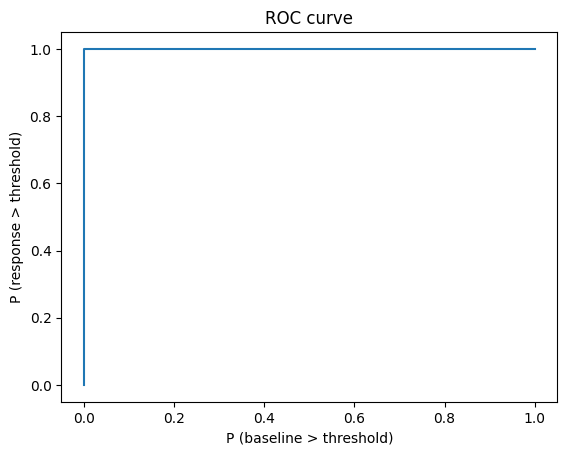

In [60]:
#plot roc curve

### your code here
plt.plot(baseline_proba, non_baseline_proba)
plt.title('ROC curve')
plt.xlabel('P (baseline > threshold)')
plt.ylabel('P (response > threshold)')
plt.show()

### Compute AUC

In [61]:
#lets use scikit-learn package to compute area under the curve

In [62]:
from sklearn.metrics import auc

In [63]:
?auc

Signature: auc(x, y)
Docstring:
Compute Area Under the Curve (AUC) using the trapezoidal rule.

This is a general function, given points on a curve.  For computing the
area under the ROC-curve, see :func:`roc_auc_score`.  For an alternative
way to summarize a precision-recall curve, see
:func:`average_precision_score`.

Parameters
----------
x : array-like of shape (n,)
    X coordinates. These must be either monotonic increasing or monotonic
    decreasing.
y : array-like of shape (n,)
    Y coordinates.

Returns
-------
auc : float
    Area Under the Curve.

See Also
--------
roc_auc_score : Compute the area under the ROC curve.
average_precision_score : Compute average precision from prediction scores.
precision_recall_curve : Compute precision-recall pairs for different
    probability thresholds.

Examples
--------
>>> import numpy as np
>>> from sklearn import metrics
>>> y = np.array([1, 1, 2, 2])
>>> pred = np.array([0.1, 0.4, 0.35, 0.8])
>>> fpr, tpr, thresholds = metrics.roc_

In [64]:
# # using roc compute auc:)

auc_result = auc(baseline_proba, non_baseline_proba)

print(f'Area under the curve = {auc_result}')

Area under the curve = 1.0


### Awesome job! You are fantastic, keep going :) If you have any questions, feel free to ask TAs for clarification.